In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
#from sklearn.mixture import GaussianMixture
%matplotlib inline

# Data to feed

In [2]:
class DataDistribution(object):
    def __init__(self, data_range, mu1, sigma1, mu2, sigma2):
        self.data_range = data_range
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.mu2 = mu2
        self.sigma2 = sigma2

    def sample(self, N):
        half_N = N // 2
        samples1 = np.random.normal(self.mu1, self.sigma1, half_N)
        samples2 = np.random.normal(self.mu2, self.sigma2, half_N)
        samples = np.concatenate((samples1, samples2))
        samples.sort()
        samples = samples / self.data_range
        return samples

In [3]:
class GeneratorDistribution(object):
    def __init__(self, data_range):
        self.data_range = data_range

    def sample(self, N):
        return np.linspace(-self.data_range, self.data_range, N) + np.random.random(N) * 0.01
        # return np.random.uniform(-self.data_range, self.data_range, size=N)

# Model

In [4]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, [None, real_dim], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    
    return inputs_real, inputs_z

In [5]:
# G(z)
def generator(z, out_dim, n_hidden=32, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        # hidden layer
        h1 = tf.layers.dense(z, n_hidden, activation=None)
        # leacky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.dense(h1, n_hidden, activation=None)
        h2 = tf.maximum(alpha * h2, h2)
        
        # logits and tanh output
        logits = tf.layers.dense(h2, out_dim, activation=None)
        out = tf.tanh(logits)
        return out

In [6]:
# D(x)
def discriminator(x, n_hidden=32, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        # hidden layer
        h1 = tf.layers.dense(x, n_hidden, activation=None)
        # leacky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.dense(h1, n_hidden, activation=None)
        h2 = tf.maximum(alpha * h2, h2)
        
        # logits and tanh output
        logits = tf.layers.dense(h2, 1, activation=None)
        out = tf.sigmoid(logits)
        return out, logits

In [7]:
def test_samples(D, G, inputs_real, inputs_z, session, data, sample_range, batch_size, num_points=10000, num_bins=100):
    # decision boundary
    xs = np.linspace(-1, 1, num_points)
    db = np.zeros((num_points, 1))
    for i in range(num_points // batch_size):
        x_ = xs[batch_size * i:batch_size * (i + 1)]
        x_ = np.reshape(x_, [batch_size, 1])
        db[batch_size * i:batch_size * (i + 1)] = session.run(D, {inputs_real: x_})

    # data distribution
    d = data.sample(num_points)
    d = d * sample_range    
    bins = np.linspace(-sample_range, sample_range, num_bins)
    pd, _ = np.histogram(d, bins=bins, density=True)

    # generated samples
    zs = np.linspace(-sample_range, sample_range, num_points)
    g = np.zeros((num_points, 1))
    for i in range(num_points // batch_size):
        z_ = zs[batch_size * i:batch_size * (i + 1)]
        z_ = np.reshape(z_, [batch_size, 1])
        g[batch_size * i:batch_size * (i + 1)] = session.run(G, {inputs_z: z_})
        g[batch_size * i:batch_size * (i + 1)] = g[batch_size * i:batch_size * (i + 1)] * sample_range
    pg, _ = np.histogram(g, bins=bins, density=True)

    return db, pd, pg

In [8]:
def plot_distributions(samps, sample_range):
    db, pd, pg = samps
    db_x = np.linspace(-sample_range, sample_range, len(db))
    p_x = np.linspace(-sample_range, sample_range, len(pd))
    f, ax = plt.subplots(1)
    ax.plot(db_x, db, label='decision boundary')
    ax.set_ylim(0, 1)
    plt.plot(p_x, pd, label='real data')
    plt.plot(p_x, pg, label='generated data')
    plt.title('1D Generative Adversarial Network')
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()

# Build Net

In [9]:
# parameters
mu1, sigma1, mu2, sigma2 = -2.5, 0.5, 2.5, 0.5
data_range = 5

# Size of input
input_size = 1
# Size of latent vector to generator
z_size = 1
# Sizes of hidden layers
n_hidden = 64
# Leak factor for leaky ReLU
alpha = 0.01
# Smoothing 
smooth = 0.1

d_learning_rate = 0.002
g_learning_rate = 0.002
n_epochs = 5001
M = 300 # batch size

In [10]:
tf.reset_default_graph()

# Create our input placeholders
inputs_real, inputs_z = model_inputs(real_dim=input_size, z_dim=z_size)

# Build the model
g_model = generator(z=inputs_z, out_dim=input_size, n_hidden=n_hidden, reuse=False, alpha=alpha)
d_model_real, d_logits_real = discriminator(x=inputs_real, n_hidden=n_hidden, reuse=False, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(x=g_model, n_hidden=n_hidden, reuse=True, alpha=alpha)

In [11]:
# Calculate losses
real_labels = tf.ones_like(d_logits_real) * (1 - smooth)
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels))

fake_labels = tf.zeros_like(d_logits_real)
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=fake_labels))

d_loss = d_loss_real + d_loss_fake

g_labels = tf.ones_like(d_logits_fake)
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels))

In [12]:
# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)

In [13]:
data = DataDistribution(data_range, mu1, sigma1, mu2, sigma2)
gen = GeneratorDistribution(data_range)

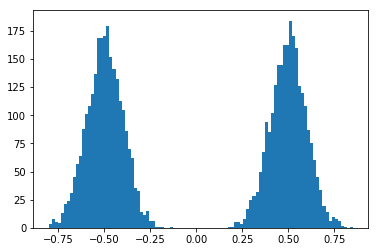

In [14]:
temp_input_normalized = data.sample(5000)
plt.hist(temp_input_normalized, bins=100)
plt.show()

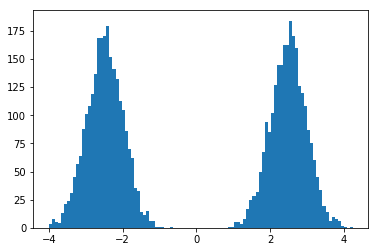

In [15]:
temp_input = temp_input_normalized * data_range
plt.hist(temp_input, bins=100)
plt.show()

In [16]:
samples = []
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(n_epochs):
        x_ = data.sample(M * input_size) # sampled m-batch from p_data
        x_ = np.reshape(x_, [M, input_size])
        z_ = gen.sample(M * z_size)  # sample m-batch from noise prior
        z_ = np.reshape(z_, [M, z_size])
        
        # Run optimizers
        _ = sess.run(d_train_opt, feed_dict={inputs_real: x_, inputs_z: z_})
        _ = sess.run(g_train_opt, feed_dict={inputs_z: z_})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {inputs_real: x_, inputs_z: z_})
        train_loss_g = g_loss.eval({inputs_z: z_})
        
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        if e % 100 == 0:
            print("Epoch {}/{}...".format(e+1, n_epochs),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))

            # Sample from generator as we're training for viewing afterwards
            number_of_samples_draw = 5000
            sample_z = gen.sample(number_of_samples_draw * z_size)
            sample_z = np.reshape(sample_z, [number_of_samples_draw, z_size])
            gen_samples = sess.run(
                           generator(inputs_z, out_dim=input_size, n_hidden=n_hidden, reuse=True),
                           feed_dict={inputs_z: sample_z})
            gen_samples = gen_samples * data_range
            samples.append(gen_samples)
        
        if e == n_epochs-1:
            samps = test_samples(d_model_real, g_model, inputs_real, inputs_z, sess, data, data_range, M)

Epoch 1/5001... Discriminator Loss: 1.3924... Generator Loss: 0.7289
Epoch 101/5001... Discriminator Loss: 1.2860... Generator Loss: 0.9681
Epoch 201/5001... Discriminator Loss: 1.2612... Generator Loss: 0.9890
Epoch 301/5001... Discriminator Loss: 1.3701... Generator Loss: 0.8201
Epoch 401/5001... Discriminator Loss: 1.4461... Generator Loss: 0.8840
Epoch 501/5001... Discriminator Loss: 1.3998... Generator Loss: 0.7930
Epoch 601/5001... Discriminator Loss: 1.2457... Generator Loss: 0.8963
Epoch 701/5001... Discriminator Loss: 1.1826... Generator Loss: 0.9339
Epoch 801/5001... Discriminator Loss: 1.2854... Generator Loss: 0.9765
Epoch 901/5001... Discriminator Loss: 1.3956... Generator Loss: 0.8151
Epoch 1001/5001... Discriminator Loss: 1.3330... Generator Loss: 0.8587
Epoch 1101/5001... Discriminator Loss: 1.3123... Generator Loss: 0.9193
Epoch 1201/5001... Discriminator Loss: 1.3511... Generator Loss: 0.8470
Epoch 1301/5001... Discriminator Loss: 1.3617... Generator Loss: 0.8260
Epoc

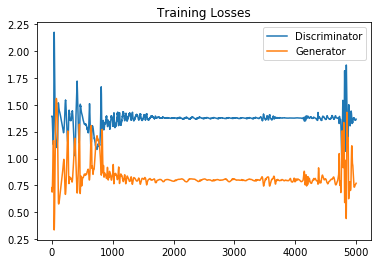

In [17]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [18]:
last_sample = samples[-1]
print(last_sample.shape)

(5000, 1)


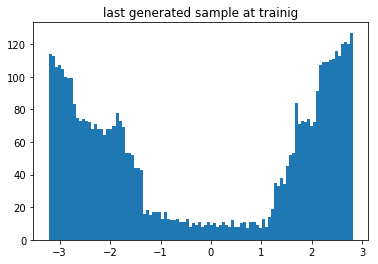

In [19]:
plt.hist(last_sample, bins=100)
plt.title('last generated sample at trainig')

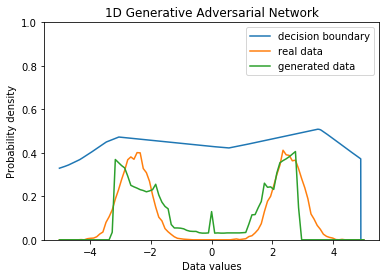

In [20]:
plot_distributions(samps, data_range)